In [ ]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 29.9 MB/s 
     |████████████████████████████████| 212 kB 10.4 MB/s 


In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.2


In [ ]:
dataset=nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
train=dataset['train']
val=dataset['validation']
test=dataset['test']

In [ ]:
def get_tweet(data):
  tweets=[x['text'] for x in data]
  labels=[x['label'] for x in data]
  return tweets,labels

In [ ]:
tweets,labels=get_tweet(train)

In [ ]:
tweets[0],labels[0]

('i didnt feel humiliated', 'sadness')

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer=Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [ ]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [ ]:
tweets[0]

'i didnt feel humiliated'

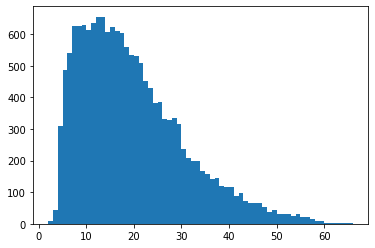

In [ ]:
lengths=[len(t.split(' ')) for t in tweets]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [ ]:
maxlen=50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer,tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences,truncating='post',padding='post',maxlen=maxlen)
  return padded

In [ ]:
padded_train_seq=get_sequences(tokenizer,tweets)

In [ ]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [ ]:
classes=set(labels)
print(classes)

{'fear', 'anger', 'sadness', 'surprise', 'joy', 'love'}


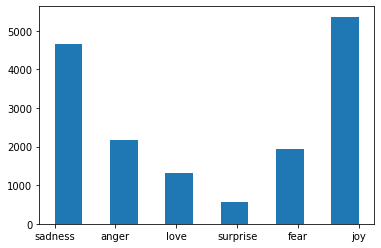

In [ ]:
plt.hist(labels,bins=11)
plt.show()

In [ ]:
class_to_index=dict((c,i) for i,c in enumerate(classes))
index_to_class=dict((v,k) for k,v in class_to_index.items())

In [ ]:
class_to_index

{'anger': 1, 'fear': 0, 'joy': 4, 'love': 5, 'sadness': 2, 'surprise': 3}

In [ ]:
index_to_class

{0: 'fear', 1: 'anger', 2: 'sadness', 3: 'surprise', 4: 'joy', 5: 'love'}

In [ ]:
names_to_ids=lambda labels: np.array([class_to_index.get(x) for x in labels])

In [ ]:
train_labels=names_to_ids(labels)
print(train_labels[0])

2


In [ ]:
model=tf.keras.models.Sequential([
      tf.keras.layers.Embedding(10000,16,input_length=maxlen),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
      tf.keras.layers.Dense(6,activation='softmax')
])

model.compile( loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [ ]:
val_tweets,val_labels=get_tweet(val)
val_seq=get_sequences(tokenizer,val_tweets)
val_labels=names_to_ids(val_labels)
              

In [ ]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 2)

In [ ]:
h=model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq,val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 17s 14ms/step - loss: 1.3449 - accuracy: 0.4590 - val_loss: 0.8347 - val_accuracy: 0.7115
Epoch 2/20
500/500 [==============================] - 6s 12ms/step - loss: 0.6276 - accuracy: 0.7799 - val_loss: 0.6255 - val_accuracy: 0.7840
Epoch 3/20
500/500 [==============================] - 6s 12ms/step - loss: 0.3678 - accuracy: 0.8764 - val_loss: 0.5028 - val_accuracy: 0.8405
Epoch 4/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2709 - accuracy: 0.9140 - val_loss: 0.4334 - val_accuracy: 0.8595
Epoch 5/20
500/500 [==============================] - 6s 11ms/step - loss: 0.1974 - accuracy: 0.9417 - val_loss: 0.4415 - val_accuracy: 0.8665
Epoch 6/20
500/500 [==============================] - 6s 11ms/step - loss: 0.1535 - accuracy: 0.9536 - val_loss: 0.4140 - val_accuracy: 0.8720
Epoch 7/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1376 - accuracy: 0.9576 - val_loss: 0.4240 - val_accuracy: 0.880

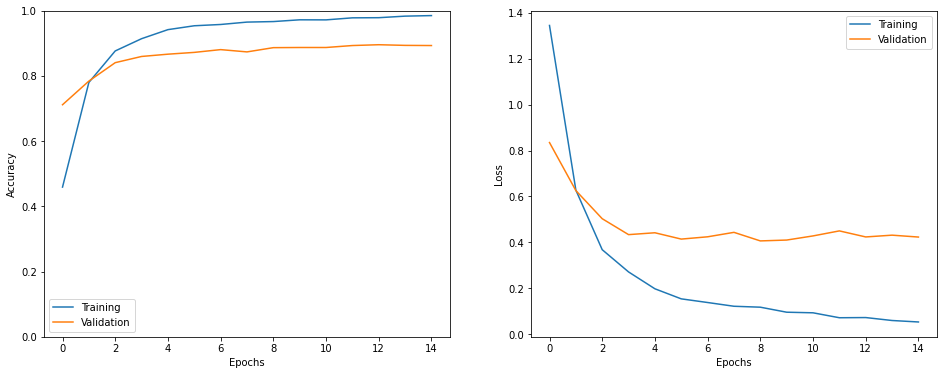

In [ ]:
show_history(h)

In [ ]:
test_tweets, test_labels=get_tweet(test)
test_seq=get_sequences(tokenizer,test_tweets)
test_labels=names_to_ids(test_labels)

In [ ]:
test_tweets[0], test_labels[0]

('im feeling rather rotten so im not very ambitious right now', 2)

In [ ]:
test_acc=model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 6ms/step - loss: 0.3958 - accuracy: 0.8880


In [ ]:
i=random.randint(0, len(test_labels)-1)

print("sentence: ", test_tweets[i])
print("emotion: ",index_to_class[test_labels[i]])

p=model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class=index_to_class[np.argmax(p).astype('uint8')]

print("predicted emotion: ",pred_class)

sentence:  i see on wednesday im feeling fantastic these days and i can tell im getting smaller and smaller
emotion:  joy
predicted emotion:  joy


In [ ]:
prediction= model.predict(test_seq)
preds= [np.argmax(i) for i in prediction]

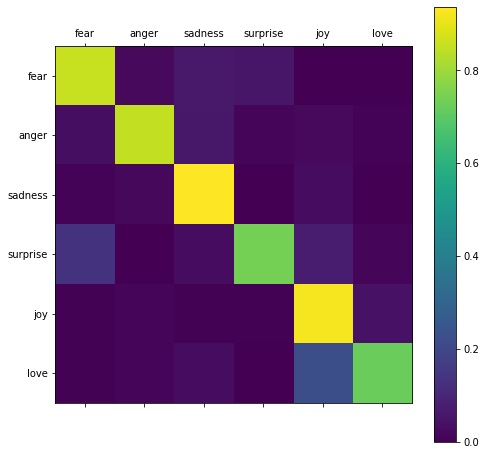

In [ ]:
show_confusion_matrix(test_labels, preds, list(classes))

In [ ]:
index_to_class

{0: 'fear', 1: 'anger', 2: 'sadness', 3: 'surprise', 4: 'joy', 5: 'love'}

Text(87.0, 0.5, 'True_value')

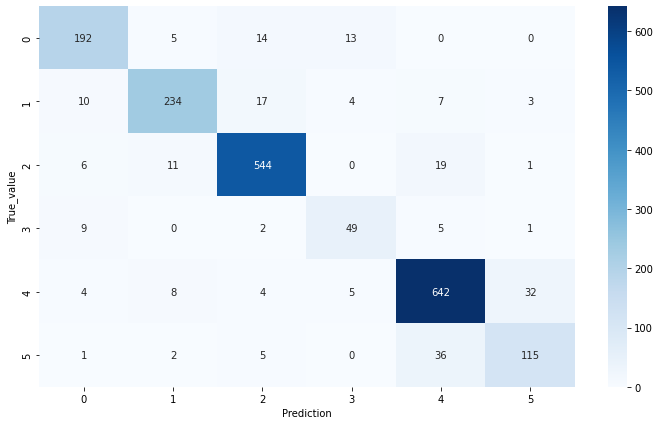

In [ ]:
import tensorflow as tf

#Confusion Matrix - verify accuracy of each class
import seaborn as sns
cm = tf.math.confusion_matrix(labels = test_labels, predictions = preds)
plt.figure(figsize = (12,7))
sns.heatmap(cm,annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Prediction')
plt.ylabel('True_value')